In [1]:
import re
import numpy as np
import pandas as pd
from datetime import date
from datetime import datetime
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict 

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
#copying the data from drive
! mkdir data

! cp /content/drive/MyDrive/MIDS\ Facebook\ Ads\ Team/AD\ DATA/2020\ Presidential\ Ads\ WITH\ TONE.csv ./data
! cp /content/drive/MyDrive/MIDS\ Facebook\ Ads\ Team/Pickles/processed_presidential_data.pkl ./data
! cp /content/drive/MyDrive/MIDS\ Facebook\ Ads\ Team/Pickles/p_data_na_body.pkl ./data

# ! cp -a /content/drive/MyDrive/MIDS\ Facebook\ Ads/. ./data

In [4]:
## reading the data file
p_data = pd.read_csv("./data/2020 Presidential Ads WITH TONE.csv", \
                     encoding="ISO-8859-1", low_memory=False)

In [43]:
print(f"Input shape: {p_data.shape}")

Input shape: (479709, 74)


In [ ]:
p_data.columns

Index(['id', 'candidate', 'party', 'ad_start_time', 'ad_stop_time',
       'page_name', 'funding_entity', 'ad_body_text', 'ad_link_caption',
       'ad_link_description', 'ad_link_title', 'ad_snapshot_url',
       'spend_lower', 'spend_upper', 'impressions_lower', 'impressions_upper',
       'male', 'female', 'age18_24', 'age25_34', 'age35_44', 'age45_54',
       'age55_64', 'age65plus', 'Alabama', 'Alaska', 'Arizona', 'Arkansas',
       'California', 'Colorado', 'Connecticut', 'Delaware', 'Florida',
       'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas',
       'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts',
       'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana',
       'Nebraska', 'Nevada', 'New_Hampshire', 'New_Jersey', 'New_Mexico',
       'New_York', 'North_Carolina', 'North_Dakota', 'Ohio', 'Oklahoma',
       'Oregon', 'Pennsylvania', 'Rhode_Island', 'South_Carolina',
       'South_Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont'

In [ ]:
p_data.head()

id     candidate  ...   Wyoming tone_category
0   604406720200059  Donald Trump  ...  0.003592      CONTRAST
1   283948239393377  Donald Trump  ...  0.005100      CONTRAST
2   286624085822005  Donald Trump  ...  0.003713      CONTRAST
3   284384622920839  Donald Trump  ...  0.004768      CONTRAST
4  2617435251846400  Donald Trump  ...  0.003078      CONTRAST

[5 rows x 74 columns]

In [5]:
# setting id column as index col
p_data.set_index('id', inplace=True)

In [6]:
# converting datatime columns
p_data.ad_start_time = pd.to_datetime(p_data.ad_start_time, format="%m/%d/%Y")
p_data.ad_stop_time = pd.to_datetime(p_data.ad_stop_time, format="%m/%d/%Y")

# A. Data Processing

## 1 - Filterning Data post primaries

In [7]:
print(f"Earliest Date: {p_data.ad_start_time.dt.date.min()}")
print(f"Latest Date  : {p_data.ad_start_time.dt.date.max()}")

Earliest Date: 2020-04-01
Latest Date  : 2020-11-03


In [8]:
#filtering the data
(p_data.ad_start_time >= pd.to_datetime("2020-04-08")).value_counts()

True     479709
False      4683
Name: ad_start_time, dtype: int64

In [9]:
p_data = p_data[p_data['ad_start_time'] >= pd.to_datetime("2020-04-08")]
print(f"Filtered dataframe shape: {p_data.shape}")

Filtered dataframe shape: (479709, 73)


## 2 - Data Profiling

In [ ]:
p_data.describe()

spend_lower    spend_upper  ...  West_Virginia        Wyoming
count  479709.000000  479709.000000  ...  479709.000000  479709.000000
mean      305.177931     461.249197  ...       0.003395       0.001234
std      2292.094297    2745.153073  ...       0.017189       0.009584
min         0.000000      99.000000  ...       0.000000       0.000000
25%         0.000000      99.000000  ...       0.000000       0.000000
50%         0.000000      99.000000  ...       0.000000       0.000000
75%         0.000000      99.000000  ...       0.003630       0.000536
max    300000.000000  349999.000000  ...       1.000000       1.000000

[8 rows x 61 columns]

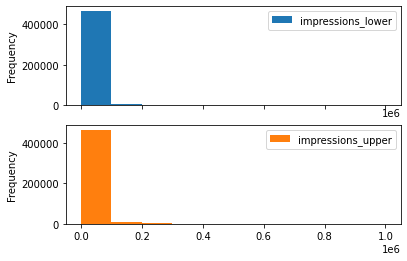

In [15]:
p_data[["impressions_lower","impressions_upper"]]\
.plot(kind='hist', subplots=True)
plt.show()

In [31]:
p_data['len_ads'] = p_data.apply(lambda row: len(str(row.ad_body_text)), axis=1)

Avg Ad length : 256
Min Ad length : 3
Max Ad length : 1208


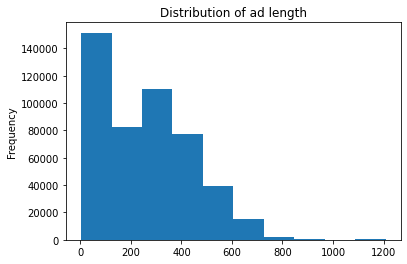

In [39]:
print(f"Avg Ad length : {round(p_data.len_ads.mean())}")
print(f"Min Ad length : {p_data.len_ads.min()}")
print(f"Max Ad length : {p_data.len_ads.max()}")
p_data.len_ads.plot(kind='hist', title="Distribution of ad length")
plt.show()

In [40]:
#getting the count of rows with Null values
pd.DataFrame(p_data.isna().sum())\
[pd.DataFrame(p_data.isna().sum())[0]>0]

0
ad_body_text         22365
ad_link_caption        448
ad_link_description  32995
ad_link_title          832
impressions_upper     1018

In [ ]:
print(f"Shape of the presidential data : {p_data.shape}")
print(f'\nCandidate wise data count : \n{p_data["candidate"].value_counts()}')

Shape of the presidential data : (479709, 73)

Candidate wise data count : 
Donald Trump    379621
Joe Biden       100088
Name: candidate, dtype: int64


In [ ]:
print(f'Total Unique ads : {len(p_data.ad_body_text.unique())}')

print(f'\nCandidate wise UNIQUE ad count : \n \
{p_data.groupby(["candidate"]).ad_body_text.nunique()}')

Total Unique ads : 3189

Candidate wise UNIQUE ad count : 
 candidate
Donald Trump    1165
Joe Biden       2023
Name: ad_body_text, dtype: int64


In [ ]:
p_data[p_data["candidate"] == "Joe Biden"].ad_body_text.unique()

array([" 450 ENDORSERS NEEDED \r\n\r\nWith ONE MONTH to the Democratic National Convention, we need to keep our momentum as strong as ever. That's why we need 450 more strong Democrats, like yourself, to sign on and endorse Joe Biden before our 11:59 PM deadline. \r\n\r\nCan we count on you to keep our momentum going by endorsing Joe today?",
       " Bring manufacturing home to American workers\r\n Build infrastructure for a clean energy future\r\n Ease the burden on working parents and caregivers\r\n\x9d Dismantle systemic racism in our communities\r\n\r\nMy plan to build our economy back better than ever will mobilize the American people in service of four bold, national efforts to address four great national challenges. We can't go back to the way things were before, and we must do better for American families. \r\n\r\nAre you with me? Sign on if you agree that we need to build back our economy better than it was before COVID-19.",
       ' FREE Phone Background \r\n\r\nChip in to 

In [ ]:
p_data[p_data["candidate"] != "Joe Biden"].ad_body_text.unique()

array([" Attention Patriots \r\n\r\nIn a little less than 5 MONTHS, the American People will decide if we are going to Keep America Great, or if we're going to let our Nation fall into the hands of a corrupt BIG GOVERNMENT SOCIALIST.\r\n\r\nThe Left has been watching my every move for the past three and a half years and hoping that my Administration and I will fail. But, because of Patriots like YOU, we keep defying the odds.\r\n\r\nPlease pledge to stand with President Trump this November.",
       " Attention Patriots \r\n\r\nIn a little less than 6 MONTHS, American People will decide if we are going to Keep America Great, or if we're going to let our Nation fall into the hands of a corrupt BIG GOVERNMENT SOCIALIST.\r\nThe Left has been watching my every move for the past three and a half years and hoping that my Administration and I will fail. But, because of Patriots like YOU, we keep defying the odds.",
       " Attention Patriots \r\n\r\nThe Left has been watching my every move f

## 3 - Handling Missing Data

### 3.1 - Missing ad_body_text

In [ ]:
#creating a new dataframe for the ads with empty ad_body_text
p_data_na_body = p_data[p_data['ad_body_text'].isna()]

#saving results
p_data_na_body.to_pickle(\
    "/content/drive/MyDrive/MIDS Facebook Ads/Pickles/p_data_na_body.pkl")


## dropping the observations with empty ad body from the primary dataframe
p_data.dropna(subset=['ad_body_text'], inplace=True)

print(f"Shape after removing ads with missing body text : {p_data.shape}")

Shape after removing ads with missing body text : (457344, 73)


### 3.2 - Missing upper_impressions

In [ ]:
print(f"Minimum impression_lower value in the missing impression_upper data : \
{min(p_data[p_data['impressions_upper'].isna()]['impressions_lower'])}")
print(f"Maximum impression_upper value in all data : \
{max(p_data['impressions_lower'])}")

Minimum impression_lower value in the missing impression_upper data : 1000000
Maximum impression_upper value in all data : 1000000


In [ ]:
# replacing missing impressions_upper value with the maxi impression_lower value
p_data['impressions_upper'] = p_data['impressions_upper'].fillna(\
                                              max(p_data['impressions_lower']))

In [ ]:
#getting the count of rows with Null values
pd.DataFrame(p_data.isna().sum())\
[pd.DataFrame(p_data.isna().sum())[0]>0]

0
ad_link_caption        263
ad_link_description  15893
ad_link_title          525

## 4 - Data cleaning

In [ ]:
# Removing \n\r >>
tqdm.pandas()
p_data['ad_body_text'] = p_data.progress_apply(lambda row : \
                  re.sub(r'\r\n\r\n|\r\n|>+', ' ', row.ad_body_text),axis = 1)

In [ ]:
tqdm.pandas()
p_data['ad_text_processed'] = p_data.progress_apply(lambda row :\
                                             row.ad_body_text.lower(),axis = 1)

## 5 - Feature Engineering

### 5.1 Average Impression

In [ ]:
tqdm.pandas()
p_data['avg_impression'] = p_data.progress_apply(lambda row: \
                   (row.impressions_lower + row.impressions_upper)//2, axis = 1)

### 5.2 Average Spend

In [ ]:
tqdm.pandas()
p_data['avg_spend'] = p_data.progress_apply(lambda row: \
                      (row.spend_lower + row.spend_upper)//2, axis = 1)

In [ ]:
sub_col_list = ['candidate','ad_body_text','impressions_lower',\
   'impressions_upper','avg_impression','spend_lower','spend_upper','avg_spend']
p_data[sub_col_list].head(5)

candidate  ... avg_spend
id                              ...          
604406720200059   Donald Trump  ...       349
283948239393377   Donald Trump  ...        49
286624085822005   Donald Trump  ...       249
284384622920839   Donald Trump  ...        49
2617435251846400  Donald Trump  ...       449

[5 rows x 8 columns]

### 5.3 Runtime of Ads

In [ ]:
tqdm.pandas()
# to be run ONLY for the original file, NOT the pickle
p_data['runtime_days'] = p_data.progress_apply(lambda row: \
                                (row.ad_stop_time-row.ad_start_time).days +1,
                                 axis = 1)

In [ ]:
p_data[['ad_start_time','ad_stop_time','runtime_days']].head()

ad_start_time ad_stop_time  runtime_days
id                                                       
604406720200059     2020-06-15   2020-06-22             8
283948239393377     2020-06-15   2020-06-15             1
286624085822005     2020-06-15   2020-06-22             8
284384622920839     2020-06-15   2020-06-15             1
2617435251846400    2020-06-15   2020-06-18             4

In [ ]:
print(f'\nCandidate wise TOTAL ads runtime (days): \n \
{p_data.groupby(["candidate"]).runtime_days.sum()}')

print(f'\nCandidate wise AVERAGE ads runtime (days): \n \
{p_data.groupby(["candidate"]).runtime_days.mean()}')


Candidate wise TOTAL ads runtime (days): 
 candidate
Donald Trump    1418494
Joe Biden        379762
Name: runtime_days, dtype: int64

Candidate wise AVERAGE ads runtime (days): 
 candidate
Donald Trump    3.746633
Joe Biden       4.823048
Name: runtime_days, dtype: float64


### 5.4 Targeted States

In [ ]:
state_list = ['Alabama', 'Alaska', 'Arizona', 'Arkansas',
       'California', 'Colorado', 'Connecticut', 'Delaware', 'Florida',
       'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas',
       'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts',
       'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana',
       'Nebraska', 'Nevada', 'New_Hampshire', 'New_Jersey', 'New_Mexico',
       'New_York', 'North_Carolina', 'North_Dakota', 'Ohio', 'Oklahoma',
       'Oregon', 'Pennsylvania', 'Rhode_Island', 'South_Carolina',
       'South_Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia',
       'Washington', 'West_Virginia', 'Wyoming']

In [ ]:
### creating three new columns ; 
# aud_state_type      : To identify kind of ads (one_state or multi_state)
# aud_state_name      : Identify the state with most impresison
# aud_state_imp_frac  : Maximum impression fraction value
# aud_state_imp_abs   : Maximum impression fraction * avg_impression

def analyze_state(row):
  max_impression = 0
  max_state = None
  for i, state in enumerate(state_list):
    if row[i] > max_impression:
      max_impression = row[i] 
      max_state = state 
  if max_impression == 1:    
    return pd.Series(['one_state', max_state, max_impression])
  return pd.Series(['multi_state', max_state, max_impression])

In [ ]:
tqdm.pandas()
p_data[["aud_state_type","aud_state_name","aud_state_imp_frac"]] = \
p_data.progress_apply(lambda row: analyze_state(row[state_list]), 
                             axis = 1, result_type="expand")

p_data['aud_state_imp_abs'] = p_data.progress_apply(lambda row: \
                   round(row.aud_state_imp_frac*row.avg_impression), axis=1)

In [ ]:
sub_col_list = ['candidate','avg_impression','aud_state_type',\
                'aud_state_name','aud_state_imp_frac','aud_state_imp_abs'] 
p_data.loc[p_data['aud_state_type']=='one_state',sub_col_list].head(5)

candidate  ...  aud_state_imp_abs
id                              ...                   
781661622365948   Donald Trump  ...                499
570461107180176   Donald Trump  ...                499
1177380979271300  Donald Trump  ...                499
538825306793135   Donald Trump  ...                499
255093819099517   Donald Trump  ...                499

[5 rows x 6 columns]

In [ ]:
p_data.loc[p_data['aud_state_type']=='multi_state',sub_col_list].head(5)

candidate  ...  aud_state_imp_abs
id                              ...                   
604406720200059   Donald Trump  ...               1039
283948239393377   Donald Trump  ...                269
286624085822005   Donald Trump  ...               3025
284384622920839   Donald Trump  ...                207
2617435251846400  Donald Trump  ...               2268

[5 rows x 6 columns]

### 5.5 Targeted Age Group

In [ ]:
age_group_list = ['age18_24', 'age25_34', 'age35_44', \
                  'age45_54', 'age55_64', 'age65plus']

In [ ]:
### creating 4 new columns
# aud_age_type    : To identify if the ads were target to a single age group;
#possible values include 'one_age_grp' and 'multi_age_grp' 
# aud_age_grp     : To identify the most targeted age group
# aud_age_imp_frac: To identify the impression fraction of the targeted group
# aud_age_imp_abs : aud_age_imp_frac * avg_impression

def analyze_age(row):
  max_impression = 0
  max_age_group = None
  for i, age_grp in enumerate(age_group_list):
    if row[i] > max_impression:
      max_impression = row[i] 
      max_age_group = age_grp 
  if max_impression == 1:    
    return pd.Series(['one_age_grp', max_age_group, max_impression])
  return pd.Series(['multi_age_grp', max_age_group, max_impression])

In [ ]:
tqdm.pandas()
p_data[["aud_age_type","aud_age_grp","aud_age_imp_frac"]] = \
p_data.progress_apply(lambda row: analyze_age(row[age_group_list]), 
                             axis = 1, result_type="expand")

p_data['aud_age_imp_abs'] = p_data.progress_apply(lambda row: \
                   round(row.aud_age_imp_frac*row.avg_impression), axis=1)

In [ ]:
sub_col_list = ['candidate','avg_impression','aud_age_type','aud_age_grp',\
                'aud_age_imp_frac','aud_age_imp_abs']
p_data[sub_col_list].head(5)

candidate  ...  aud_age_imp_abs
id                              ...                 
604406720200059   Donald Trump  ...             6874
283948239393377   Donald Trump  ...              875
286624085822005   Donald Trump  ...             6525
284384622920839   Donald Trump  ...              700
2617435251846400  Donald Trump  ...            10350

[5 rows x 6 columns]

### 5.6 Targeted Gender

In [ ]:
### creating 4 new columns
# aud_gen_type    : To identify if the ads were target to one gender or multi;
#possible values include 'one_gender' and 'multi_gender' 
# aud_gen_grp     : To identify the most targeted gender group
# aud_gen_imp_frac: To identify the impression fraction of the targeted group
# aud_gen_imp_abs : aud_gen_imp_frac * avg_impression

def analyze_gender(row):
  max_impression = 0
  max_gen_group = None
  for i, gen_grp in enumerate(['male','female']):
    if row[i] > max_impression:
      max_impression = row[i] 
      max_gen_group = gen_grp 
  if max_impression == 1:    
    return pd.Series(['one_gender', max_gen_group, max_impression])
  return pd.Series(['multi_gender', max_gen_group, max_impression])

In [ ]:
tqdm.pandas()
p_data[["aud_gen_type","aud_gen_grp","aud_gen_imp_frac"]] = \
p_data.progress_apply(lambda row: analyze_gender(row[['male','female']]), 
                             axis = 1, result_type="expand")

p_data['aud_gen_imp_abs'] = p_data.progress_apply(lambda row: \
                   round(row.aud_gen_imp_frac*row.avg_impression), axis=1)

In [ ]:
sub_col_list = ['candidate','aud_gen_type','aud_gen_grp',\
                'aud_gen_imp_frac','aud_gen_imp_abs']
p_data[sub_col_list].head(5)

candidate  aud_gen_type  ... aud_gen_imp_frac  aud_gen_imp_abs
id                                            ...                                  
604406720200059   Donald Trump  multi_gender  ...             0.74             9249
283948239393377   Donald Trump  multi_gender  ...             0.76             1899
286624085822005   Donald Trump  multi_gender  ...             0.73            16424
284384622920839   Donald Trump  multi_gender  ...             0.64             1599
2617435251846400  Donald Trump  multi_gender  ...             0.73            16424

[5 rows x 5 columns]

In [ ]:
#saving results
p_data.to_pickle("/content/drive/MyDrive/MIDS Facebook Ads/Pickles/processed_presidential_data.pkl")

### 5.7 Translation of ads

In [ ]:
p_data['ad_text_processed'].head()

id
604406720200059      attention patriots  in a little less than 5 m...
283948239393377      attention patriots  in a little less than 5 m...
286624085822005      attention patriots  in a little less than 5 m...
284384622920839      attention patriots  in a little less than 5 m...
2617435251846400     attention patriots  in a little less than 5 m...
Name: ad_text_processed, dtype: object

In [ ]:
from utils import Translator
lang_translator = Translator.cust_Translate()  

In [ ]:
lang_translator.translate(text="Buenos días")

In [ ]:
col_list = ["candidate","ad_text_processed"]
unique_ads = p_data[col_list].drop_duplicates()
print(f"Number of unique ads : {len(unique_ads)}")

Number of unique ads : 3177


In [ ]:
# Detecting language 
tqdm.pandas()
unique_ads["ad_lang"]= unique_ads.progress_apply(lambda row: \
                              lang_translator.detect(row.ad_text_processed),\
                                 axis = 1)

In [ ]:
# translating non-english ads
tqdm.pandas()
unique_ads["ad_en"]= unique_ads.progress_apply(lambda row: \
                      lang_translator.translate(text=row.ad_text_processed, \
                                                  source = row.ad_lang),\
                                                  axis = 1)

In [ ]:
unique_ads[unique_ads.ad_lang == "es"].head(5)

candidate  ...                                              ad_en
id                             ...                                                   
637037753836958  Donald Trump  ...  President Trump wants everyone to live the Ame...
337277027468380  Donald Trump  ...  the left engages in acts of repudiation.  Demo...
180271542944067  Donald Trump  ...  -appointed two pro-life judges of the supreme ...
224531561966281  Donald Trump  ...                    stand with Catholics for trump.
219575362711811  Donald Trump  ...             sign up for Catholics for trump today!

[5 rows x 4 columns]

In [ ]:
unique_ads.groupby(["candidate","ad_lang"]).ad_lang.count()

candidate     ad_lang
Donald Trump  en         1148
              es            6
Joe Biden     cy            1
              en         1948
              es           73
              is            1
Name: ad_lang, dtype: int64

In [ ]:
#merging the unique data with primary data_frame
p_data = p_data.merge(unique_ads, \
                    on = ["candidate","ad_text_processed"], how='left')

In [ ]:
# replacing the ad_text_processed with all english ads
tqdm.pandas()
p_data['ad_text_processed'] = p_data.progress_apply(lambda row :\
                                             row.ad_en.lower(),axis = 1)

In [ ]:
#saving results
p_data.to_pickle("/content/drive/MyDrive/MIDS Facebook Ads/Pickles/processed_presidential_data.pkl")

*****
# B. Text Analysis

## 1 - Identifying Tone

In [ ]:
keywords_tone_df = pd.read_csv("./data/keywords_for_tone.csv") 
keywords_tone_df.head()

candidate    kind       keyword
0  Donald Trump  Attack     joe biden
1  Donald Trump  Attack         biden
2  Donald Trump  Attack           joe
3  Donald Trump  Attack    sleepy joe
4  Donald Trump  Attack  barack obama

In [ ]:
keywords_tone_df.groupby(['candidate','kind']).count()

keyword
candidate    kind             
Donald Trump Advocacy       81
             Attack         66
Joe Biden    Advocacy       64
             Attack         34

In [ ]:
trump_attack = list(keywords_tone_df[\
                              (keywords_tone_df['candidate']=="Donald Trump")\
                            & (keywords_tone_df['kind']=="Attack")]['keyword'])

trump_advocacy = list(keywords_tone_df[\
                              (keywords_tone_df['candidate']=="Donald Trump")\
                          & (keywords_tone_df['kind']=="Advocacy")]['keyword'])

biden_attack = list(keywords_tone_df[\
                              (keywords_tone_df['candidate']=="Joe Biden")\
                            & (keywords_tone_df['kind']=="Attack")]['keyword'])

biden_advocacy = list(keywords_tone_df[\
                              (keywords_tone_df['candidate']=="Joe Biden")\
                          & (keywords_tone_df['kind']=="Advocacy")]['keyword'])


In [ ]:
def identify_tone(ad_text="", candidate=""):
  if ad_text == "" or candidate == "":
    raise ValueError("Empty values passed!")
  
  attack_flag = False
  advocacy_flag = False

  if candidate == "Joe Biden":
    if any(k_w in ad_text for k_w in biden_attack):
      attack_flag = True
    if any(k_w in ad_text for k_w in biden_advocacy):
      advocacy_flag = True
  else:
    if any(k_w in ad_text for k_w in trump_attack):
      attack_flag = True
    if any(k_w in ad_text for k_w in trump_advocacy):
      advocacy_flag = True

  if attack_flag and not advocacy_flag:
    return "Attack"
  elif not attack_flag and advocacy_flag:
    return "Advocacy"
  elif attack_flag and advocacy_flag:
    return "Contrast"
  else:
    return "Neutral"

In [ ]:
col_list = ["candidate","ad_en"]
unique_ads = p_data[col_list].drop_duplicates().reset_index()
print(f"Number of unique ads : {len(unique_ads)}")

Number of unique ads : 3173


In [ ]:
tqdm.pandas()
unique_ads["tone_category"]= \
unique_ads.progress_apply(lambda row: identify_tone(row.ad_en, 
                                                    row.candidate),\
                          axis = 1)

In [ ]:
unique_ads.head()

index  ... tone_category
0      0  ...      Contrast
1     15  ...      Contrast
2     44  ...      Contrast
3     71  ...      Contrast
4    234  ...      Contrast

[5 rows x 4 columns]

In [ ]:
unique_ads.tone_category.value_counts()

Advocacy    1405
Contrast     914
Attack       497
Neutral      357
Name: tone_category, dtype: int64

In [ ]:
unique_ads.to_pickle("/content/drive/MyDrive/MIDS Facebook Ads/Pickles/tone_output.pkl")

In [ ]:
p_data = p_data.merge(unique_ads, on =["candidate","ad_en"], how='left')

## 2 - Identifying Actions

In [ ]:
keywords_actions_df = pd.read_csv("./data/keywords_for_actions.csv") 
keywords_actions_df.head()

action    keyword   URLs (ad_link_caption)
0  Donate      donat      secure.actblue.com 
1  Donate  contribut       secure.winred.com 
2  Donate    chip in               winred.com
3  Donate    step up  donaldjtrump.com/donate
4  Donate        FEC                      NaN

In [ ]:
keywords_actions_df.action.value_counts()

Purchase merchandise                 17
Sign a petition or card              14
Take a poll or survey                13
Attend an event                      13
Vote                                 12
Find your polling place              10
Sign up or volunteer for campaign     9
Donate                                9
Register to vote                      8
Enter a competition                   4
Get information                       2
Name: action, dtype: int64

In [ ]:
keywords_actions_dict = defaultdict(list)
for i in range(len(keywords_actions_df)): 
  keywords_actions_dict[keywords_actions_df.iloc[i,0]]\
  .append(keywords_actions_df.iloc[i,1].lower())

In [ ]:
col_list = ["candidate","tone_category","ad_en"]
unique_ads = p_data[col_list].drop_duplicates().reset_index()
print(f"Number of unique ads : {len(unique_ads)}")

Number of unique ads : 3227


In [ ]:
# creating 11 new columns to categorize ads based on action
act_column_dict = defaultdict(int)
def identify_action(row, print_ad=False):
  if print_ad:
    print(row)
  for key in keywords_actions_dict.keys():
    act_column_dict[key] = 0

  for key in act_column_dict.keys():
    if any(term in row \
           for term in keywords_actions_dict[key]):
      act_column_dict[key] = 1
  if sum(list(act_column_dict.values())) == 0:
    return list(act_column_dict.values())+[1]
  return list(act_column_dict.values())+[0]

In [ ]:
tqdm.pandas()
unique_ads[list(act_column_dict.keys())+["No_Action"]]= \
unique_ads.progress_apply(lambda row: identify_action(row.ad_en),\
                          axis = 1, result_type="expand")

In [ ]:
# unique_ads.head()
unique_ads[list(act_column_dict.keys())+["No_Action"]].sum()

Donate                                951
Vote                                  379
Register to vote                       99
Find your polling place                61
Sign up or volunteer for campaign     110
Get information                        21
Take a poll or survey                 443
Sign a petition or card               296
Attend an event                       239
Purchase merchandise                   81
Enter a competition                    19
No_Action                            1089
dtype: int64

In [ ]:
unique_ads.head()

index     candidate  ... Enter a competition No_Action
0      0  Donald Trump  ...                   0         1
1     15  Donald Trump  ...                   0         1
2     44  Donald Trump  ...                   0         0
3     71  Donald Trump  ...                   0         1
4    234  Donald Trump  ...                   0         1

[5 rows x 16 columns]

In [ ]:
unique_ads.to_pickle("/content/drive/MyDrive/MIDS Facebook Ads/Pickles/actions_output.pkl")

In [ ]:
p_data = p_data.merge(unique_ads, on =["candidate","ad_en"], how='left')

## 3 - Identifying Issues

In [ ]:
keywords_issues_df = pd.read_csv("./data/keywords_for_issues.csv")

In [ ]:
keywords_issues_df.head()

issue            keyword
0  foreign_policy_issue        immigration
1  foreign_policy_issue          immigrant
2  foreign_policy_issue  national security
3  foreign_policy_issue      taxpayer fund
4  foreign_policy_issue           military

In [ ]:
keywords_issues_df.issue.value_counts()

economic_issue          18
social_issue            17
foreign_policy_issue    17
social_welfare_issue    11
law_order_issue         10
covid                    3
Name: issue, dtype: int64

In [ ]:
keywords_issues_dict = defaultdict(list)
for i in range(len(keywords_issues_df)): 
  keywords_issues_dict[keywords_issues_df.iloc[i,0]]\
  .append(keywords_issues_df.iloc[i,1].lower())

In [ ]:
col_list = ["candidate","tone_category","ad_en"]
unique_ads = p_data[col_list].drop_duplicates().reset_index()
print(f"Number of unique ads : {len(unique_ads)}")

Number of unique ads : 3227


In [ ]:
# creating 6 new columns to categorize ads based on issues
issue_column_dict = defaultdict(int)
def identify_issue(row, print_ad=False):
  if print_ad:
    print(row)
  for key in keywords_issues_dict.keys():
    issue_column_dict[key] = 0

  for key in issue_column_dict.keys():
    if any(term in row \
           for term in keywords_issues_dict[key]):
      issue_column_dict[key] = 1
  if sum(list(issue_column_dict.values())) == 0:
    return list(issue_column_dict.values())+[1]
  return list(issue_column_dict.values())+[0]

In [ ]:
tqdm.pandas()
unique_ads[list(issue_column_dict.keys())+["No_Issue"]]= \
unique_ads.progress_apply(lambda row: identify_issue(row.ad_en),\
                          axis = 1, result_type="expand")

In [ ]:
# unique_ads.head()
unique_ads[list(issue_column_dict.keys())+["No_Issue"]].sum()

foreign_policy_issue     142
law_order_issue           87
economic_issue           188
social_issue              31
social_welfare_issue     114
covid                    140
No_Issue                2657
dtype: int64

In [ ]:
unique_ads.head()

index     candidate tone_category  ... social_welfare_issue  covid  No_Issue
0      0  Donald Trump      CONTRAST  ...                    0      0         1
1     15  Donald Trump      CONTRAST  ...                    0      0         1
2     44  Donald Trump      CONTRAST  ...                    0      0         0
3     71  Donald Trump      CONTRAST  ...                    0      0         1
4    234  Donald Trump      CONTRAST  ...                    0      0         1

[5 rows x 11 columns]

In [ ]:
unique_ads.to_pickle("/content/drive/MyDrive/MIDS Facebook Ads/Pickles/issues_output.pkl")

In [ ]:
p_data = p_data.merge(unique_ads, on =["candidate","ad_en"], how='left')

## 4 - Key-Phrase Extraction

### 4.1 Extraction

In [ ]:
import pandas as pd
p_data = pd.read_pickle("/content/drive/MyDrive/MIDS Facebook Ads/Pickles/processed_presidential_data.pkl")

In [ ]:
#!pip install azure-ai-textanalytics
from utils import KeyPhraseExtractor
kp_extractor = KeyPhraseExtractor.KeyPhraseExtractor()  

In [ ]:
kp_extractor.extract(p_data.loc[0,'ad_en'])

['america great',
 'corrupt big government socialist',
 'american people',
 'attention patriots',
 'half years']

In [ ]:
col_list = ["candidate","ad_en"]
unique_ads = p_data[col_list].drop_duplicates()
print(f"Number of unique ads : {len(unique_ads)}")

Number of unique ads : 3173


In [ ]:
tqdm.pandas()
unique_ads["key_phrase"]= unique_ads.progress_apply(lambda row: \
                              kp_extractor.extract(row.ad_en),\
                                 axis = 1)

In [ ]:
unique_ads.head()

candidate  ...                                         key_phrase
0    Donald Trump  ...  [america great, corrupt big government sociali...
15   Donald Trump  ...  [america great, corrupt big government sociali...
44   Donald Trump  ...  [action plan survey, nation's military, radica...
71   Donald Trump  ...  [america great, attention republicans, corrupt...
234  Donald Trump  ...  [america great, attention republicans, corrupt...

[5 rows x 3 columns]

In [ ]:
unique_ads.to_pickle("/content/drive/MyDrive/MIDS Facebook Ads/Pickles/key_phrase.pkl")

### 4.2 Analysis

In [ ]:
unique_ads = pd.read_pickle("/content/drive/MyDrive/MIDS Facebook Ads/Pickles/key_phrase.pkl")

In [ ]:
p_data.tone_category.value_counts()

ADVOCACY    216236
CONTRAST    143901
ATTACK       75383
NEUTRAL      21824
Name: tone_category, dtype: int64

In [ ]:
ad_tot_imps = p_data[['ad_en','avg_impression','tone_category']]\
              .groupby(['ad_en','tone_category'])\
              .sum()\
              .reset_index()
ad_tot_imps

ad_en  ... avg_impression
0      450 endorsers needed  with one month to the d...  ...        21483.0
1      attention patriots  in a little less than 5 m...  ...       238985.0
2      attention patriots  in a little less than 6 m...  ...        86471.0
3      attention patriots  the left has been watchin...  ...        13473.0
4      attention republicans  in a little less than ...  ...       359337.0
...                                                 ...  ...            ...
3222  ð°your $50 contribution will quadruple to $2...  ...       442905.0
3223  ð£ calling all ohio veterans and military fa...  ...        32499.0
3224  ð£ guess who's campaigning for ohio? ð£  j...  ...        42499.0
3225  ð£we need you, now! ð£ every weekend from ...  ...       119996.0
3226  ð¬save the usps ð¬ this pandemic has only ...  ...        13473.0

[3227 rows x 3 columns]

In [ ]:
ad_tot_imps = ad_tot_imps.merge(unique_ads, on=["ad_en"], how='left')

In [ ]:
ad_tot_imps.head()

ad_en  ...                                         key_phrase
0   450 endorsers needed  with one month to the d...  ...  [joe biden, democratic national convention, pm...
1   attention patriots  in a little less than 5 m...  ...  [america great, corrupt big government sociali...
2   attention patriots  in a little less than 6 m...  ...  [america great, corrupt big government sociali...
3   attention patriots  the left has been watchin...  ...  [action plan survey, nation's military, radica...
4   attention republicans  in a little less than ...  ...  [america great, attention republicans, corrupt...

[5 rows x 5 columns]

In [ ]:
word_freq_dict = defaultdict(lambda : defaultdict(lambda: defaultdict(int)))

In [ ]:
for i in tqdm(range(len(ad_tot_imps))):
  for j in ad_tot_imps.loc[i,'key_phrase']:
    word_freq_dict[ad_tot_imps.loc[i,'candidate']]\
                  [ad_tot_imps.loc[i,'tone_category']]\
                  [j] += ad_tot_imps.loc[i,'avg_impression']

In [ ]:
kp_stats_df = pd.DataFrame(columns=['candidate','tone_category',
                                    'keyPhrase','tot_impression'])

In [ ]:
for k1, v1 in tqdm(word_freq_dict.items()):
  for k2, v2 in tqdm(v1.items()):
    for k3, v3 in v2.items():
      kp_stats_df = kp_stats_df.append({'candidate': k1, 
                                        'tone_category':k2,
                                        'keyPhrase': k3, 
                                        'tot_impression':v3 }, 
                                       ignore_index=True)

In [ ]:
kp_stats_df

candidate  ... tot_impression
0        Joe Biden  ...    193272085.0
1        Joe Biden  ...     15576130.0
2        Joe Biden  ...        42966.0
3        Joe Biden  ...        42966.0
4        Joe Biden  ...        51968.0
...            ...  ...            ...
6339  Donald Trump  ...       424936.0
6340  Donald Trump  ...       424936.0
6341  Donald Trump  ...       424936.0
6342  Donald Trump  ...       573932.0
6343  Donald Trump  ...       573932.0

[6344 rows x 4 columns]

In [ ]:
kp_stats_df.to_csv("/content/drive/MyDrive/MIDS Facebook Ads/Stats_csv/key_phrase.csv", index=False)
# results analyzed in Tableau

## 5 - Sentiment Analysis

### 5.1 Extraction

In [ ]:
%%capture
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

In [ ]:
## Adding sample words to check the effect of altered lexicon on sentiment value
word_dict = {
    "crazy" : -5,
    "crooked" : -5,
    "sleepy" : -5, 
    "radical" : -5,
    "fake news" : -5,
}

sid.lexicon.update(word_dict)

In [ ]:
#considering unique ads 
col_list = ["candidate","tone_category","ad_en"]
unique_ads = p_data[col_list].drop_duplicates()
print(f"Number of unique ads : {len(unique_ads)}")

Number of unique ads : 3227


In [ ]:
def analyze_sentiment(text):
  lines_in_text = text.split('.')
  sentiment_arr = []
  for line in lines_in_text:
    if len(line) > 1:
      polarity = sid.polarity_scores(line)
      sentiment_arr.append(polarity['compound'])

  max_s = round(max(sentiment_arr),2)
  min_s = round(min(sentiment_arr),2)
  avg_s = round(np.average(sentiment_arr),2)
  
  return sentiment_arr, max_s, min_s, avg_s

In [ ]:
tqdm.pandas()
unique_ads[["sent_arr","sent_max","sent_min","sent_avg"]]= \
unique_ads.progress_apply(lambda row: analyze_sentiment(row.ad_en), \
                          axis = 1, result_type="expand")

### 5.2 Analysis

In [ ]:
unique_ads.head()

candidate tone_category  ... sent_min sent_avg
0    Donald Trump      CONTRAST  ...    -0.18     0.32
15   Donald Trump      CONTRAST  ...    -0.18     0.32
44   Donald Trump      CONTRAST  ...    -0.18     0.35
71   Donald Trump      CONTRAST  ...    -0.18     0.32
234  Donald Trump      CONTRAST  ...    -0.18     0.32

[5 rows x 7 columns]

In [ ]:
unique_ads.to_csv("/content/drive/MyDrive/MIDS Facebook Ads/Stats_csv/sentiments.csv", index=False)
# results analyzed in Tableau

In [ ]:
p_data = p_data.merge(unique_ads, on =["candidate","ad_en"], how='left')

In [ ]:
p_data.to_pickle("/content/drive/MyDrive/MIDS Facebook Ads/Pickles/processed_presidential_data.pkl")

## 6 - Named Entity Recognition 

### 6.1 Extraction

In [ ]:
# !pip install azure-ai-textanalytics

In [ ]:
from utils import NER
ner_obj = NER.NER()

In [ ]:
#considering unique ads 
col_list = ["candidate","tone_category","ad_en"]
unique_ads = p_data[col_list].drop_duplicates()
print(f"Number of unique ads : {len(unique_ads)}")

Number of unique ads : 3227


In [ ]:
tqdm.pandas()
unique_ads['ner_result'] = unique_ads.progress_apply(lambda row: \
                                           ner_obj.get_ne(row.ad_en), axis=1)

In [ ]:
unique_ads.head(10)

candidate  ...                                      ner_result
0    Donald Trump  ...                               [(trump, Person)]
15   Donald Trump  ...                                              []
44   Donald Trump  ...                                              []
71   Donald Trump  ...                                              []
234  Donald Trump  ...                                              []
263  Donald Trump  ...                                              []
290  Donald Trump  ...                                              []
453  Donald Trump  ...                                              []
482  Donald Trump  ...                                              []
509  Donald Trump  ...  [(amy coney barrett, Person), (trump, Person)]

[10 rows x 4 columns]

In [ ]:
print(f"Number of ads with entities : \
{len([lst for lst in unique_ads.ner_result if len(lst) > 0])}")

Number of ads with entities : 2704


In [ ]:
unique_ads.to_pickle("/content/drive/MyDrive/MIDS Facebook Ads/Pickles/NER_output.pkl")

### 6.2 Analysis

In [ ]:
NER_unique_ads = pd.read_pickle("/content/drive/MyDrive/MIDS Facebook Ads/Pickles/NER_output.pkl")

In [ ]:
NER_unique_ads

candidate  ...                                         ner_result
0       Donald Trump  ...                                  [(trump, Person)]
15      Donald Trump  ...                                                 []
44      Donald Trump  ...                                                 []
71      Donald Trump  ...                                                 []
234     Donald Trump  ...                                                 []
...              ...  ...                                                ...
457026     Joe Biden  ...                                                 []
457256     Joe Biden  ...  [(donald trump, Person), (trump, Person), (gen...
457273     Joe Biden  ...  [(donald trump, Person), (trump, Person), (gen...
457295     Joe Biden  ...  [(polls, Event), (obama, Person), (clinton, Pe...
457322     Joe Biden  ...                           [(donald trump, Person)]

[3227 rows x 4 columns]

In [ ]:
ad_tot_imps = p_data[['ad_en','avg_impression','tone_category']]\
              .groupby(['ad_en','tone_category'])\
              .sum()\
              .reset_index()
ad_tot_imps

ad_en  ... avg_impression
0      450 endorsers needed  with one month to the d...  ...        21483.0
1      attention patriots  in a little less than 5 m...  ...       238985.0
2      attention patriots  in a little less than 6 m...  ...        86471.0
3      attention patriots  the left has been watchin...  ...        13473.0
4      attention republicans  in a little less than ...  ...       359337.0
...                                                 ...  ...            ...
3222  ð°your $50 contribution will quadruple to $2...  ...       442905.0
3223  ð£ calling all ohio veterans and military fa...  ...        32499.0
3224  ð£ guess who's campaigning for ohio? ð£  j...  ...        42499.0
3225  ð£we need you, now! ð£ every weekend from ...  ...       119996.0
3226  ð¬save the usps ð¬ this pandemic has only ...  ...        13473.0

[3227 rows x 3 columns]

In [ ]:
NER_unique_ads = NER_unique_ads.merge(ad_tot_imps, on=["ad_en","tone_category"], how="left")

In [ ]:
NER_unique_ads.head()

candidate tone_category  ...         ner_result avg_impression
0  Donald Trump      CONTRAST  ...  [(trump, Person)]       238985.0
1  Donald Trump      CONTRAST  ...                 []        86471.0
2  Donald Trump      CONTRAST  ...                 []        13473.0
3  Donald Trump      CONTRAST  ...                 []       359337.0
4  Donald Trump      CONTRAST  ...                 []       190971.0

[5 rows x 5 columns]

In [ ]:
NER_df = pd.DataFrame(columns=["candidate","tone_category","entity_type",
                               "entity_name","tot_impression"])

In [ ]:
for i in tqdm(range(len(NER_unique_ads))):
  entities = NER_unique_ads.loc[i,'ner_result']
  candidate = NER_unique_ads.loc[i,'candidate']
  impression = NER_unique_ads.loc[i,'avg_impression']
  tone = NER_unique_ads.loc[i,'tone_category']
  if len(entities)>0:
    for entity in entities:
      NER_df = NER_df.append({
                      "candidate": candidate,
                      "tone_category": tone,
                      "entity_type": entity[1],
                      "entity_name": entity[0],
                      "tot_impression": impression
                      },ignore_index=True)

In [ ]:
NER_df.shape

(5970, 5)

In [ ]:
NER_df = NER_df.groupby(["candidate","tone_category","entity_type","entity_name"])\
         .sum()\
         .reset_index()

In [ ]:
NER_df.head()

candidate tone_category entity_type    entity_name  tot_impression
0  Donald Trump      ADVOCACY       Event           2020     114620477.0
1  Donald Trump      ADVOCACY       Event  america first          7485.0
2  Donald Trump      ADVOCACY       Event       birthday     108991994.0
3  Donald Trump      ADVOCACY       Event           camp        565995.0
4  Donald Trump      ADVOCACY       Event       campaign       9756804.0

In [ ]:
NER_df.entity_type.value_counts()

Person     646
Event      221
Product    146
Name: entity_type, dtype: int64

In [ ]:
NER_df[NER_df['entity_type']=='Product'].value_counts()

candidate     tone_category  entity_type  entity_name  tot_impression
Joe Biden     NEUTRAL        Product      envelope     33495.0           1
Donald Trump  ADVOCACY       Product      trump mask   247472.0          1
              ATTACK         Product      ice cream    668288.0          1
                                          freezer      668288.0          1
                                          fossil       4536901.0         1
                                                                        ..
Joe Biden     ADVOCACY       Product      stickers     8107338.0         1
                                          sticker      8147318.0         1
                                          steel        112499.0          1
                                          shades       67427.0           1
Donald Trump  ADVOCACY       Product      ad           4138627.0         1
Length: 146, dtype: int64

In [ ]:
NER_df.to_csv("/content/drive/MyDrive/MIDS Facebook Ads/Stats_csv/NER.csv", 
              index=False)
# results analyzed in Tableau

# Miscellaneous

In [44]:
p_data = pd.read_pickle("/content/drive/MyDrive/MIDS Facebook Ads/Pickles/processed_presidential_data.pkl")

In [45]:
#considering unique ads 
col_list = ["candidate","tone_category","ad_en"]
unique_ads = p_data[col_list].drop_duplicates()
print(f"Number of unique ads : {len(unique_ads)}")

Number of unique ads : 3227


In [48]:
unique_ads.reset_index(inplace=True)

In [89]:
for i in range(len(unique_ads)):
  if "freezer" in unique_ads.loc[i,'ad_en']:
    print(unique_ads.loc[i,'candidate'], unique_ads.loc[i,'ad_en'])

Donald Trump the so-called democrat 'leaders' should immediately come back to washington and approve legislation to help american families. but instead, they are on an endless vacation at your expense. nancy doesn't care if americans suffer as long as she can be on vacation eating $13 pints of ice cream from her $24,000 freezer! nancy and chuck are killing american jobs. it's obvious they won't listen to their president, but maybe they will listen to you, the american people. please take our official survey today to tell the do nothing democrats that they need to fund the payment protection program immediately.


In [56]:
unique_ads.head()

index  ...                                              ad_en
0      0  ...   attention patriots  in a little less than 5 m...
1     15  ...   attention patriots  in a little less than 6 m...
2     44  ...   attention patriots  the left has been watchin...
3     71  ...   attention republicans  in a little less than ...
4    234  ...   attention republicans  in a little less than ...

[5 rows x 4 columns]

****
END
****